In [1]:
import numpy as np
import math
import random
from matplotlib import pyplot as plt
from IPython.display import clear_output


In [16]:
PI = 3.1415926
e = 2.71828


In [17]:
def get_rand_number(min_value, max_value):
    """

    This function gets a random number from a uniform distribution between
    the two input values [min_value, max_value] inclusively
    Args:
    - min_value (float)
    - max_value (float)
    Return:
    - random number between this range (float)
    """

    range = max_value - min_value

    choice = random.uniform(0,1)
    return min_value + range*choice


In [28]:
def f_of_x(x):
    """
    This is the main function we want to integrate over.
    Args:
    - x(float) : input to function; must be in radians
    Return:
    - output of function  f(x) (float)
    """

    return (e**(-1*x))/(1+(x-1)**2)


In [29]:
def crude_monte_carlo(num_samples=5000):
    """
    This function performs the Crude Monte Carlo for our
    specific function f(x) on the range x=0 to x=5.
    Notice that this bound is sufficient because f(x)
    approaches 0 at around PI
    -args:
    - num_samples (float) : number of samples
    Return:
    - Crude Monte Carlo Estimation (float)
    """
    lower_bound = 0
    upper_bound = 5

    sum_of_samples = 0

    for i in range(num_samples):
        x = get_rand_number(lower_bound, upper_bound)
        sum_of_samples += f_of_x(x)
    
    return (upper_bound - lower_bound) * float(sum_of_samples/num_samples)


In [33]:
crude_monte_carlo(10000)

0.6930259644449028

In [36]:
def get_crude_MC_variance(num_samples):
    """
    This function returns the variance fo the Crude Monte Carlo.
    Note that the inputed number of samples does not neccissarily
    need to correspond to number of samples used in the Monte
    Carlo Simulation.
    Args:
    - num_samples (int)
    Return:
    - Variance for Crude Monte Carlo approximation of f(x) (float)
    """
    int_max = 5 # this is the max of our integration range
    
    # get the average of squares
    running_total = 0
    for i in range(num_samples):
        x = get_rand_number(0, int_max)
        running_total += f_of_x(x)**2
    sum_of_sqs = running_total*int_max / num_samples
    
    # get square of average
    running_total = 0
    for i in range(num_samples):
        x = get_rand_number(0, int_max)
        running_total = f_of_x(x)
    sq_ave = (running_total*int_max/num_samples)**2
    
    return sum_of_sqs - sq_ave

In [40]:
# Now we will run a Crude Monte Carlo simulation with 10000 samples
# We will also calculate the variance with 10000 samples and the error

MC_samples = 10000
var_samples = 10000 # number of samples we will use to calculate the variance
crude_estimation = crude_monte_carlo(MC_samples)
variance = get_crude_MC_variance(var_samples)
error = math.sqrt(variance/MC_samples)

# display results
print(f"Monte Carlo Approximation of f(x): {crude_estimation}")
print(f"Variance of Approximation: {variance}")
print(f"Error in Approximation: {error}")

Monte Carlo Approximation of f(x): 0.7186773291196458
Variance of Approximation: 0.2661519534067423
Error in Approximation: 0.005158991698062154


# Importance of sampling
## Determine Optimal Weight Function Template


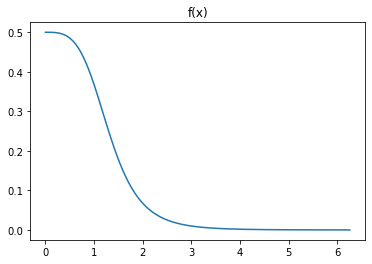

In [41]:
# plot the function
xs = [float(i/50) for i in range(int(50*PI*2))]
ys = [f_of_x(x) for x in xs]
plt.plot(xs,ys)
plt.title("f(x)");

## Propose Weigth Function Template

$g(x) = A*exp(-\lambda x)$

After we find the ideal values for A and λ, we’ll be able to construct this plot of f(x) and our optimal weight function g(x):

In [42]:
# this is the template of our weight function g(x)
def g_of_x(x, A, lamda):
    e = 2.7182818
    return A*math.pow(e, -1*lamda*x)

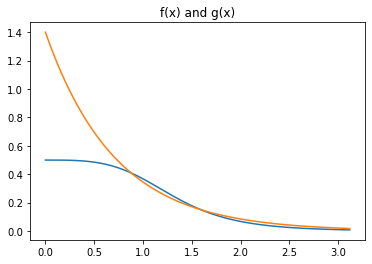

In [43]:

xs = [float(i/50) for i in range(int(50*PI))]
fs = [f_of_x(x) for x in xs]
gs = [g_of_x(x, A=1.4, lamda=1.4) for x in xs]
plt.plot(xs, fs)
plt.plot(xs, gs)
plt.title("f(x) and g(x)");

## Determine the Optimal Parameters for Our Weight Function

In [44]:
def inverse_G_of_r(r, lamda):
    return (-1 * math.log(float(r)))/lamda

In [46]:
def get_IS_variance(lamda, num_samples):
    """
    This function calculates the variance if a Monte Carlo
    using importance sampling.
    Args:
    - lamda (float) : lambda value of g(x) being tested
    Return: 
    - Variance
    """
    A = lamda
    int_max = 5
    
    # get sum of squares
    running_total = 0
    for i in range(num_samples):
        x = get_rand_number(0, int_max)
        running_total += (f_of_x(x)/g_of_x(x, A, lamda))**2
    
    sum_of_sqs = running_total / num_samples
    
    # get squared average
    running_total = 0
    for i in range(num_samples):
        x = get_rand_number(0, int_max)
        running_total += f_of_x(x)/g_of_x(x, A, lamda)
    sq_ave = (running_total/num_samples)**2
    
    
    return sum_of_sqs - sq_ave

In [47]:
# get variance as a function of lambda by testing many
# different lambdas

test_lamdas = [i*0.05 for i in range(1, 61)]
variances = []

for i, lamda in enumerate(test_lamdas):
    print(f"lambda {i+1}/{len(test_lamdas)}: {lamda}")
    A = lamda
    variances.append(get_IS_variance(lamda, 10000))
    clear_output(wait=True)
    
optimal_lamda = test_lamdas[np.argmin(np.asarray(variances))]
IS_variance = variances[np.argmin(np.asarray(variances))]

print(f"Optimal Lambda: {optimal_lamda}")
print(f"Optimal Variance: {IS_variance}")
print((IS_variance/10000)**0.5)

Optimal Lambda: 1.6500000000000001
Optimal Variance: 0.04787918082343101
0.0021881311849025645


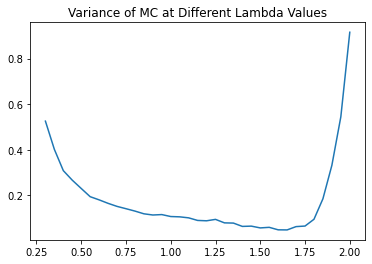

In [48]:
plt.plot(test_lamdas[5:40], variances[5:40])
plt.title("Variance of MC at Different Lambda Values");

## Perform Importance Sampling Monte Carlo with Optimized Weight Function

In [49]:
def importance_sampling_MC(lamda, num_samples):
    A = lamda
    
    running_total = 0
    for i in range(num_samples):
        r = get_rand_number(0,1)
        running_total += f_of_x(inverse_G_of_r(r, lamda=lamda))/g_of_x(inverse_G_of_r(r, lamda=lamda), A, lamda)
    approximation = float(running_total/num_samples)
    return approximation

In [50]:
# run simulation
num_samples = 10000
approx = importance_sampling_MC(optimal_lamda, num_samples)
variance = get_IS_variance(optimal_lamda, num_samples)
error = (variance/num_samples)**0.5

# display results
print(f"Importance Sampling Approximation: {approx}")
print(f"Variance: {variance}")
print(f"Error: {error}")

Importance Sampling Approximation: 0.6977363020346731
Variance: 0.04582035230735371
Error: 0.002140568903524334


# Monte Carlo Simulations for AMD options (time series simulation)


In [2]:
#Import Libraries
import numpy as np  
import pandas as pd  
import pandas_datareader as wb  
import matplotlib.pyplot as plt  
from scipy.stats import norm
%matplotlib inline

#Settings for Monte Carlo asset data, how long, and how many forecasts 
ticker = 'AMD' # stock ticker
t_intervals = 30 # time steps forecasted into future
iterations = 25 # amount of simulations
#Acquiring data
data = pd.DataFrame()
data[ticker] = wb.DataReader(ticker, data_source='yahoo', start='2018-1-1')['Adj Close']
#Preparing log returns from data
log_returns = np.log(1 + data.pct_change())
#Plot of asset historical closing price
data.plot(figsize=(10, 6));

ModuleNotFoundError: No module named 'pandas_datareader'